# #013 Multiple Linear Regression

In this code, we will implement a Fama–French three-factor model to perform multiple linear regression.
<p>
The model is generated using data from the K. French Database, incorporating a 1-month TBill rate to calculate the risk-free rate (RF) and stock closing prices obtained from Yfinance. The data is consolidated into a DataFrame and adjusted using ordinary least squares (OLS).
<p>
Finally, the results are visualized using Seaborn (sns) in a scatterplot matrix.
<p>
To predict the Total Excess Return, the Fama-French model employs three explanatory variables: market excess return (MKTRF), size (SMB), and value (HML).
<p>
The model can be solved into a DataFrame where each column represents an independent variable (X), and the predicted values (Y) are in the last column, calculated as Y = pct.change - RF.

## 13.1 Estimate a Regression

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Download Fama-French factors data
ff_factors = pd.read_csv('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip', skiprows=3)
ff_factors.columns = ['Date', 'Mkt-RF', 
                      'SMB', 'HML', 'RF']
ff_factors.dropna(inplace=True)
ff_factors['Date'] = pd.to_datetime(ff_factors['Date'], 
                                    format='%Y%m%d')
ff_factors.set_index('Date', inplace=True)
display(ff_factors)

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.10,-0.25,-0.27,0.009
1926-07-02,0.45,-0.33,-0.06,0.009
1926-07-06,0.17,0.30,-0.39,0.009
1926-07-07,0.09,-0.58,0.02,0.009
1926-07-08,0.21,-0.38,0.19,0.009
...,...,...,...,...
2024-07-25,-0.30,1.49,0.67,0.021
2024-07-26,1.10,0.57,-0.19,0.021
2024-07-29,-0.02,-1.04,-0.44,0.021


In [3]:
# Download stock data (example: JPMorgan Chase & Co.)
stock_data = yf.download('JPM', start='2020-01-01', end='2024-01-01')
stock_data['Return'] = stock_data['Adj Close'].pct_change()*100
stock_data.dropna(inplace=True)
display(stock_data)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2020-01-03,137.500000,139.229996,137.080002,138.339996,121.231659,10386800,-1.319634
2020-01-06,136.559998,138.270004,136.500000,138.229996,121.135246,10259000,-0.079528
2020-01-07,137.279999,137.860001,135.820007,135.880005,119.075912,10531300,-1.700029
2020-01-08,135.699997,137.580002,135.600006,136.940002,120.004807,9695300,0.780086
2020-01-09,138.050003,138.229996,137.039993,137.440002,120.442947,9469000,0.365103
...,...,...,...,...,...,...,...
2023-12-22,167.500000,168.229996,167.229996,167.399994,164.497726,6574900,-0.059702
2023-12-26,167.460007,168.770004,167.179993,168.389999,165.470566,4683600,0.591400
2023-12-27,167.839996,169.470001,167.580002,169.399994,166.463043,6428600,0.599791


In [4]:
# Merge stock data with Fama-French factors
df = pd.merge(stock_data['Return'], 
              ff_factors, 
              left_index=True, right_index=True)
df.dropna(inplace=True)
df['Excess_Return'] = df['Return']-df['RF'] 
df = df[['Mkt-RF', 'SMB', 'HML', 'Excess_Return']]
display(df)

,Mkt-RF,SMB,HML,Excess_Return
Date,,,,
2020-01-03,-0.67,0.38,0.00,-1.325634
2020-01-06,0.36,-0.07,-0.55,-0.085528
2020-01-07,-0.19,-0.01,-0.25,-1.706029
2020-01-08,0.47,-0.05,-0.66,0.774086
2020-01-09,0.65,-0.64,-0.48,0.359103
...,...,...,...,...
2023-12-22,0.20,0.64,0.10,-0.080702
2023-12-26,0.48,0.71,0.43,0.570400
2023-12-27,0.16,0.14,0.10,0.578791


In [5]:
# Define the independent variables (factors) and dependent variable (stock return)
X = df[['Mkt-RF', 'SMB', 'HML']]
y = df['Excess_Return']
# Add a constant to the independent variables
X = sm.add_constant(X)

# Perform the multiple linear regression
model = sm.OLS(y, X).fit()
# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     1071.
Date:                Wed, 18 Sep 2024   Prob (F-statistic):          8.27e-312
Time:                        21:11:20   Log-Likelihood:                -1481.1
No. Observations:                1005   AIC:                             2970.
Df Residuals:                    1001   BIC:                             2990.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0090      0.033     -0.269      0.7

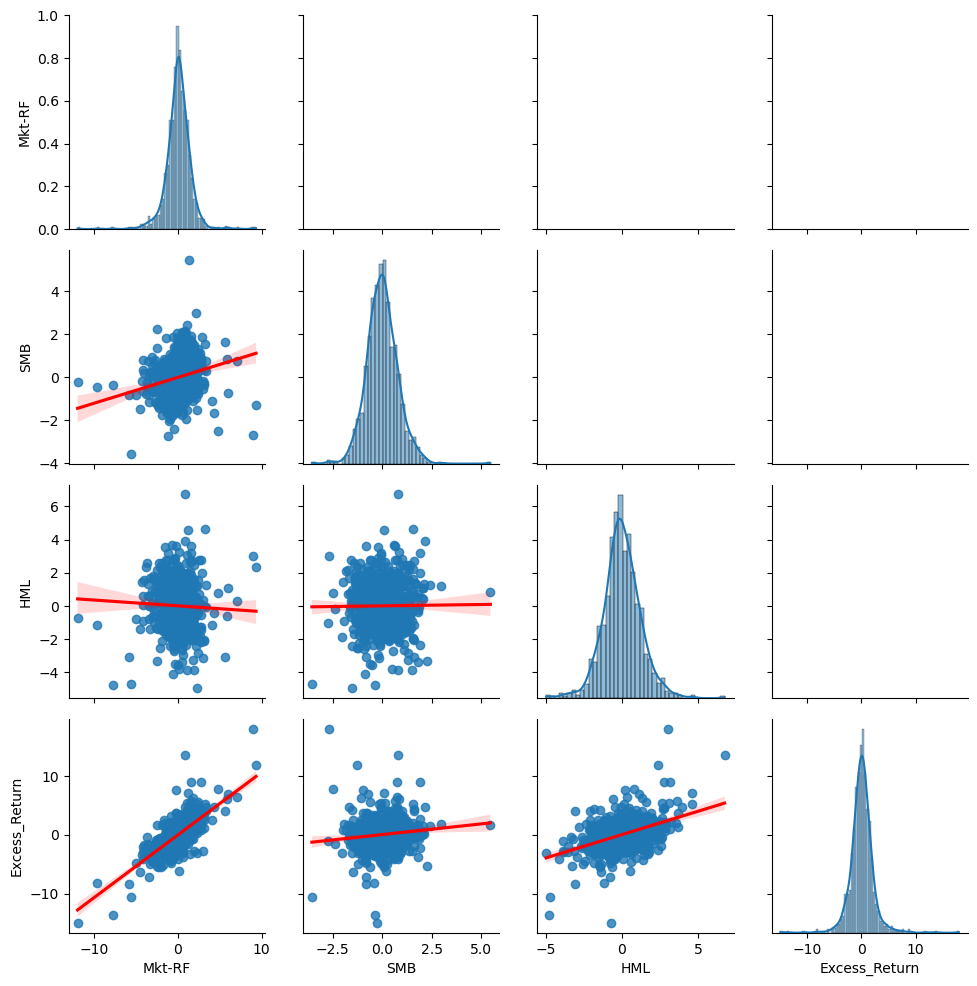

In [6]:
# Generate a scatterplot matrix
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.regplot,line_kws=dict(color="r"), ) #if no specified CI is 0.95
g.map_diag(sns.histplot, kde=True, lw=2, )

## 13.2 Visual Inspection

A more effective evaluation can be achieved using a scatterplot of residuals against the predicted values (Y^).<p>

This scatterplot helps uncover potential assumption violations and identify outliers in the data.<p>

Additionally, a scatterplot of residuals against the independent variables can be used to evaluate partial coefficients.<p>

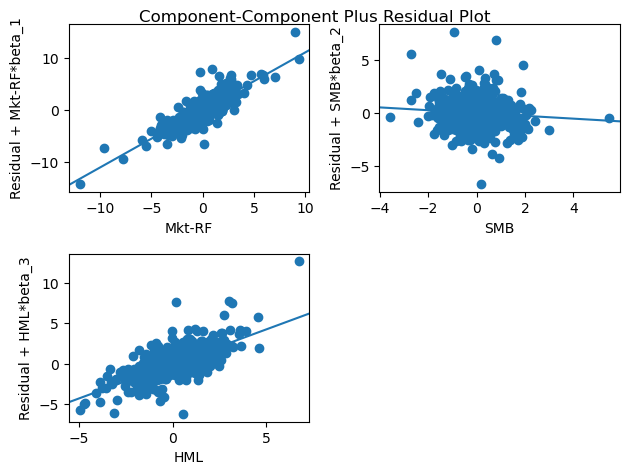

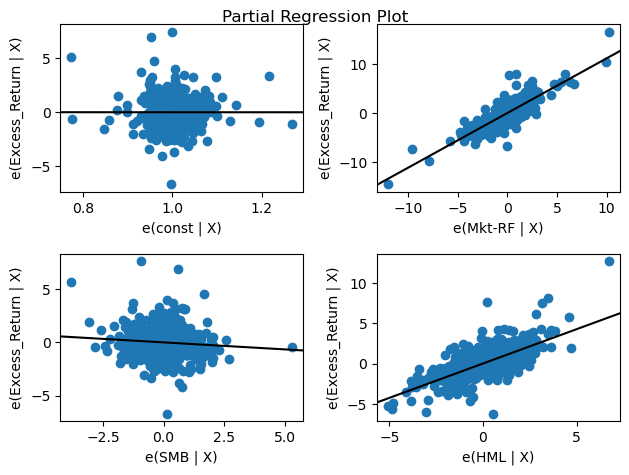

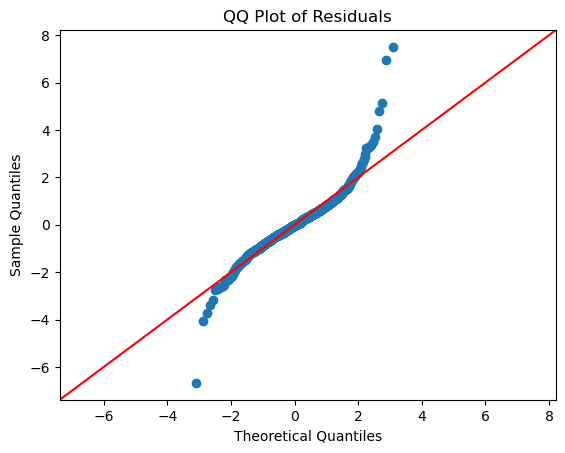

In [7]:
# analisys of residuals
# Residuals vs Factors (independent variables)
fig = sm.graphics.plot_ccpr_grid(model)
plt.show()  

# Residuals vs predicted value of dependent variable (Y^)
fig = sm.graphics.plot_partregress_grid(model)
plt.show()

# Generate a QQ plot
sm.qqplot(model.resid, line='45')
plt.title('QQ Plot of Residuals')
plt.show()